# Teaching Data Science

Prof Miles Berry

University of Roehampton

24 February 2023

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://bit.ly/atmconf2021)

Press space to move on, click in a box to edit, shift-enter to run.

# Applications

## Data analysis in Python: 
## Working with historical weather data

## Start with interesting questions

* Is winter wetter than summer?
* Is spring hotter than autumn?
* Has the climate changed?

For this, we'll import some of Python's libraries rather than creating all this ourselves!

In [59]:
import pandas as pd # data handling toolbox
import requests     # tool to download data off the web
import datetime     # dates and times are horrible. This makes things a little easier.
import seaborn as sns # nice graphics toolbox, built on, and transforming matplotlib
import matplotlib.pyplot as plt # graphics toolbox
sns.set()           # ggplot style graphs
import scipy.stats as stats # statistical testing


We'll also download the historical (month by month) weather data for the Heathrow weather station from the [UK Met Office](https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data) website. 

If you're going to try this in school, use something more local?

In [2]:
url = 'https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/oxforddata.txt'
raw = requests.get(url, allow_redirects=True)
open('data.txt', 'wb').write(raw.content)

106861

What follows is unpleasant.

Transforming the data into a usable format is non-trivial, requires attention to detail and is specific to the particular use case.

In general, do this for pupils, or have them do this in Excel where they can see what they're doing.

In [22]:
dataset = pd.read_csv("data.txt", skiprows=[0,1,2,3,4,5],
                      names=['yyyy', 'mm', 'tmax', 'tmin', 'af', 'rain', 'sun', 'notes'],
                      delim_whitespace=True, on_bad_lines='warn', na_values='---')
dataset['sun'] = dataset['sun'].str.replace(r'#', '', regex=True)
dataset = dataset.replace(r'\*', '', regex=True)
dataset = dataset.drop([0])
dataset['date'] = dataset.apply(lambda x: datetime.date(int(x['yyyy']), int(x['mm']), 1), axis=1)
dataset.index = dataset['date']
dataset.index = pd.to_datetime(dataset.index)
dataset.index = dataset.index.to_period('M')
dataset = dataset.drop(['date'], axis=1)
dataset = dataset.drop(['notes'], axis=1)
dataset['mm'] = dataset['mm'].astype('int')
dataset['tmax'] = dataset['tmax'].astype('float')
dataset['tmin'] = dataset['tmin'].astype('float')
dataset['af'] = dataset['af'].astype('float', errors='ignore')
dataset['rain'] = dataset['rain'].astype('float')
dataset['sun'] = dataset['sun'].astype('float', errors='ignore')
dataset = dataset[['yyyy','mm','tmin','tmax','af','rain','sun']]
dataset[-3:].round(1)

,yyyy,mm,tmin,tmax,af,rain,sun
date,,,,,,,
2022-11,2022,11,7.7,13.0,0.0,103.5,75.4
2022-12,2022,12,0.7,6.9,12.0,4.4,57.8
2023-01,2023,1,2.7,8.4,7.0,57.2,86.1


Adding columns to identify seasons and decades, and calculate the average monthly temperature.

In [23]:
seasons = {12: 'winter', 1: 'winter', 2: 'winter',
           3: 'spring', 4: 'spring', 5: 'spring',
           6: 'summer', 7: 'summer', 8: 'summer',
           9: 'autumn', 10: 'autumn', 11: 'autumn'}

dataset['season'] = ((dataset.index.month).map(seasons))
dataset['decade'] = ((dataset.index.year).map(lambda y: str(y // 10) + '0s'))

dataset['temp'] = (dataset['tmax']+dataset['tmin'])/2

dataset[-5:]

,yyyy,mm,tmin,tmax,af,rain,sun,season,decade,temp
date,,,,,,,,,,
2022-09,2022,9,11.2,20.7,0.0,42.7,128.8,autumn,2020s,15.95
2022-10,2022,10,10.0,17.7,0.0,79.2,145.0,autumn,2020s,13.85
2022-11,2022,11,7.7,13.0,0.0,103.5,75.4,autumn,2020s,10.35
2022-12,2022,12,0.7,6.9,12.0,4.4,57.8,winter,2020s,3.80
2023-01,2023,1,2.7,8.4,7.0,57.2,86.1,winter,2020s,5.55


So what have we got here?

In [24]:
dataset.describe().round(1)

,mm,tmin,tmax,af,rain,sun,temp
count,2041.0,2040.0,2041.0,2040.0,2041.0,1129.0,2040.0
mean,6.5,6.2,14.0,3.7,54.7,128.6,10.1
std,3.5,4.2,5.7,5.3,31.4,62.8,4.9
min,1.0,-5.8,-0.2,0.0,0.5,18.2,-3.0
25%,3.0,2.8,9.0,0.0,31.4,72.7,6.0
50%,6.0,5.7,13.8,1.0,49.7,123.2,9.7
75%,9.0,10.2,19.1,6.0,74.8,174.1,14.6
max,12.0,15.7,27.4,28.0,192.9,322.8,21.1


## We might start by just exploring the data we have.

We hardly had any rain last May here. How unusual was that?

In [17]:
dataset[dataset.rain <= 3].sort_values(by='rain')

,yyyy,mm,tmin,tmax,temp,af,rain,sun,season,decade
date,,,,,,,,,,
1995-08,1995,8,15.6,27.0,21.30,0.0,0.3,295.3,summer,1990s
2018-06,2018,6,13.1,24.2,18.65,0.0,0.4,234.5,summer,2010s
1978-10,1978,10,8.4,17.1,12.75,0.0,1.6,98.4,autumn,1970s
2020-05,2020,5,9.1,21.1,15.10,0.0,2.0,308.6,spring,2020s
1956-02,1956,2,-3.6,2.9,-0.35,22.0,2.3,NaN,winter,1950s
1959-02,1959,2,1.2,7.4,4.30,7.0,2.4,54.8,winter,1950s
1993-02,1993,2,2.5,7.2,4.85,2.0,2.4,51.0,winter,1990s
2011-04,2011,4,8.6,19.7,14.15,0.0,2.4,218.0,spring,2010s


We can easily summarise the data. 

What's the average temperature for each month of the year?

In [31]:
monthlyaverage=dataset.groupby(dataset.index.month).temp.mean().round(1) 
monthlyaverage

date
1      4.2
2      4.6
3      6.3
4      8.8
5     12.0
6     15.2
7     17.1
8     16.7
9     14.3
10    10.6
11     6.8
12     4.8
Name: temp, dtype: float64

OK, but what does that look like on a graph?

<AxesSubplot:xlabel='date', ylabel='temp'>

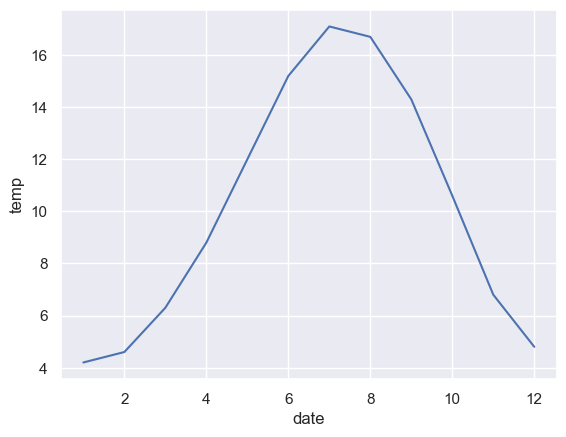

In [32]:
sns.lineplot(monthlyaverage)

## Can we have a look at those season questions now?

* Is winter wetter than summer?
* Is spring hotter than autumn?

In [39]:
dataset.groupby(dataset.season,sort=False).mean().drop(columns=['mm']).round(1)

,tmin,tmax,af,rain,sun,temp
season,,,,,,
winter,1.7,7.2,9.4,53.4,61.8,4.5
spring,4.7,13.4,3.4,47.3,155.7,9.0
summer,11.6,21.1,0.0,57.0,193.1,16.3
autumn,6.9,14.2,2.1,61.3,104.0,10.6


Comparing rainfall by season:

<AxesSubplot:xlabel='rain', ylabel='season'>

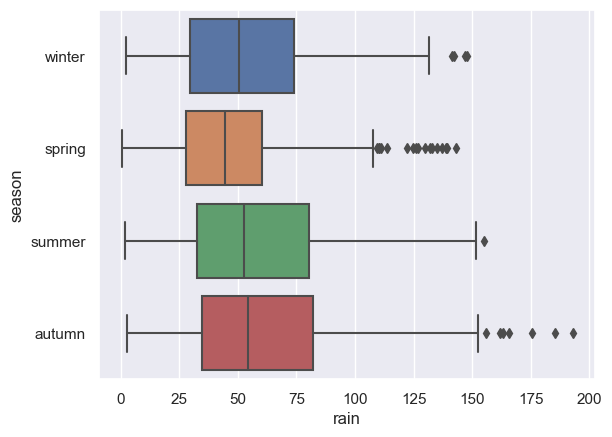

In [38]:
sns.boxplot(data=dataset,x='rain',y='season')

OK, so there's a difference between winter and summer, but is that significant?

In [40]:
stats.ttest_ind(dataset[dataset['season'] == 'winter'].rain,
                dataset[dataset['season'] == 'summer'].rain)

Ttest_indResult(statistic=-1.8908800481729415, pvalue=0.058923830705056066)

What about the temperatures?

<AxesSubplot:xlabel='temp', ylabel='season'>

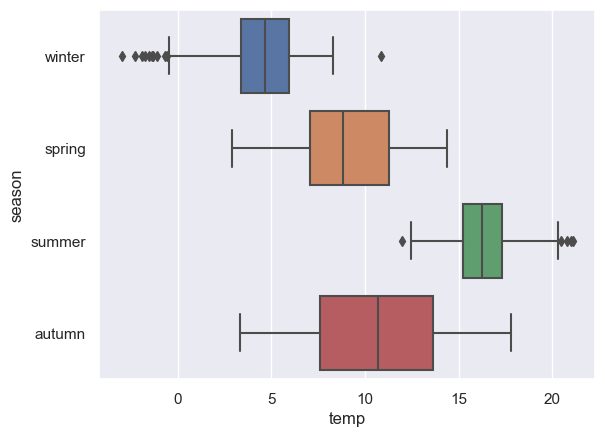

In [42]:
sns.boxplot(data=dataset,x='temp',y='season')

There's a difference between spring and autumn, but is *this* significant?

In [43]:
stats.ttest_ind(dataset[dataset['season'] == 'spring'].temp,
                dataset[dataset['season'] == 'autumn'].temp)

Ttest_indResult(statistic=-7.897135508051093, pvalue=7.359790710337107e-15)

## Does this data have anything to say about climate change?

How has the temperature varied over the years the data has been collected?

<AxesSubplot:xlabel='date', ylabel='temp'>

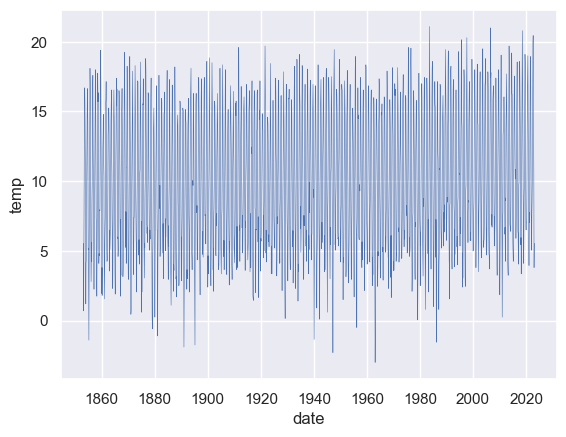

In [47]:
sns.lineplot(x=dataset.index.end_time,y=dataset.temp,linewidth=0.4)

So there's a periodic pattern - summers *are* warmer than winters, but is there any overall trend?

<AxesSubplot:xlabel='date', ylabel='temp'>

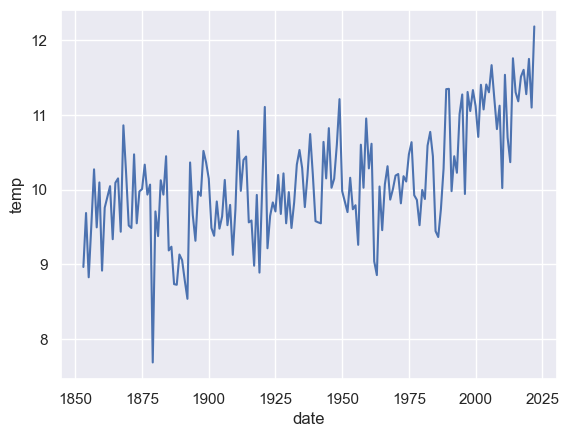

In [53]:
dataset1=dataset[dataset.index.year<2023]
sns.lineplot(x=dataset1.index.year,y=dataset1.temp,errorbar=None)

Well, it seems to be sloping up a bit, but it's a bit hard to see.

Are there any other ways to visualise this?

<AxesSubplot:>

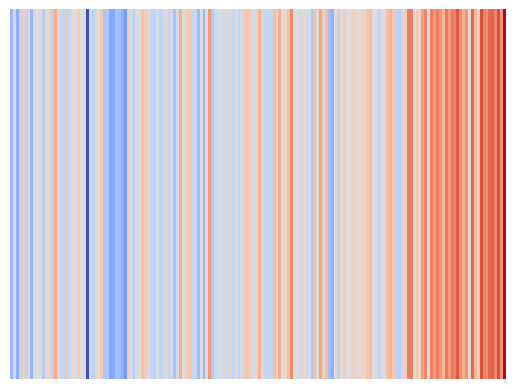

In [54]:
annual = dataset1.resample('A').mean()
sns.heatmap([annual['temp']],
            cbar=False, xticklabels=False, yticklabels=False, cmap='coolwarm')

Hey, that looks great. Could we get that on flipflops maybe? 
More details [here](https://en.wikipedia.org/wiki/Warming_stripes). 

![Warming Stripes](https://cdn.vox-cdn.com/uploads/chorus_asset/file/15274135/Screen_Shot_2019_03_04_at_12.05.58_PM.png)

OK, so that's year by year. What about over the decades?

<AxesSubplot:xlabel='decade', ylabel='temp'>

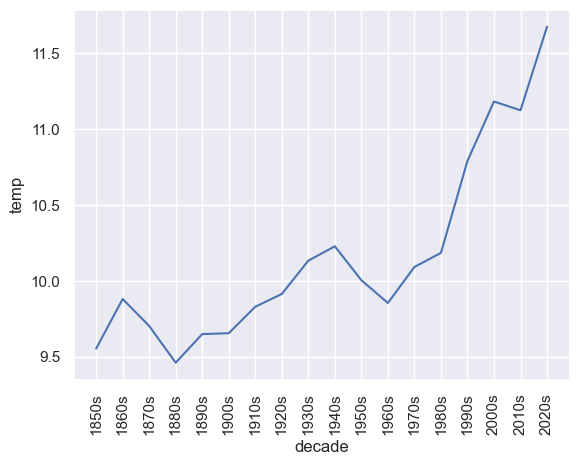

In [61]:
plot=sns.lineplot(x=dataset1.decade,y=dataset1.temp,errorbar=None)
plt.setp(plot.get_xticklabels(), rotation=90)
plot

What about a five year, rolling average?

<AxesSubplot:xlabel='date', ylabel='temps'>

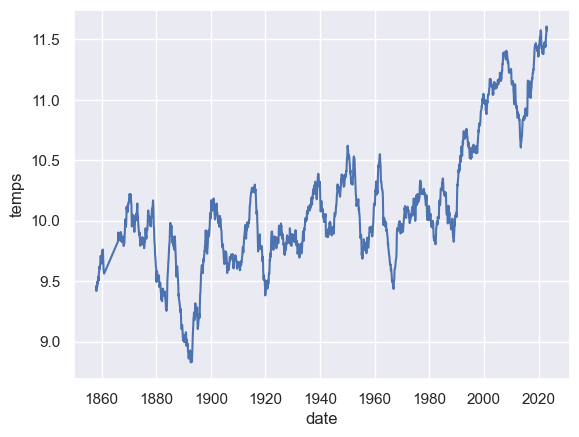

In [63]:
dataset['temps'] = dataset.temp.rolling(window=60).mean()
sns.lineplot(x=dataset.index.end_time, y=dataset.temps)